In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *
import json

import seaborn as sns
import matplotlib.pyplot as plt

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the list of experiments from JSON
with open(os.path.join('config.json'), 'r') as f:
    experiments = json.load(f)
    
path_to_hnets = './Models/Models_HNET'

# Experiment 0: Assessing Catastrophic Forgetting

### To have more robust results, once data was generated we permuted the task order 3 times, always keeping the baseline as the first task.

#### Here the first version of the experiment, we will call it V0.

In [3]:
experiment0_hnet_v0 = 'Experiment76'
models_exp0_hnet_v0 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v0)))


path_results_exp0_v0 = './Results/' + experiment0_hnet_v0
with open(os.path.join(path_results_exp0_v0 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v0 = pickle.load(fp)

data_path_exp0_v0 = './Data/Sim_Data_'+'Experiment60_sorted'+'.pkl'
with open(os.path.join(data_path_exp0_v0), 'rb') as fp:
    data_exp0_v0 = pickle.load(fp)

In [4]:
df_exp0_v0 = build_catas_forg_df(results_hnet_exp0_v0, data_exp0_v0, models_exp0_hnet_v0, experiment0_hnet_v0)

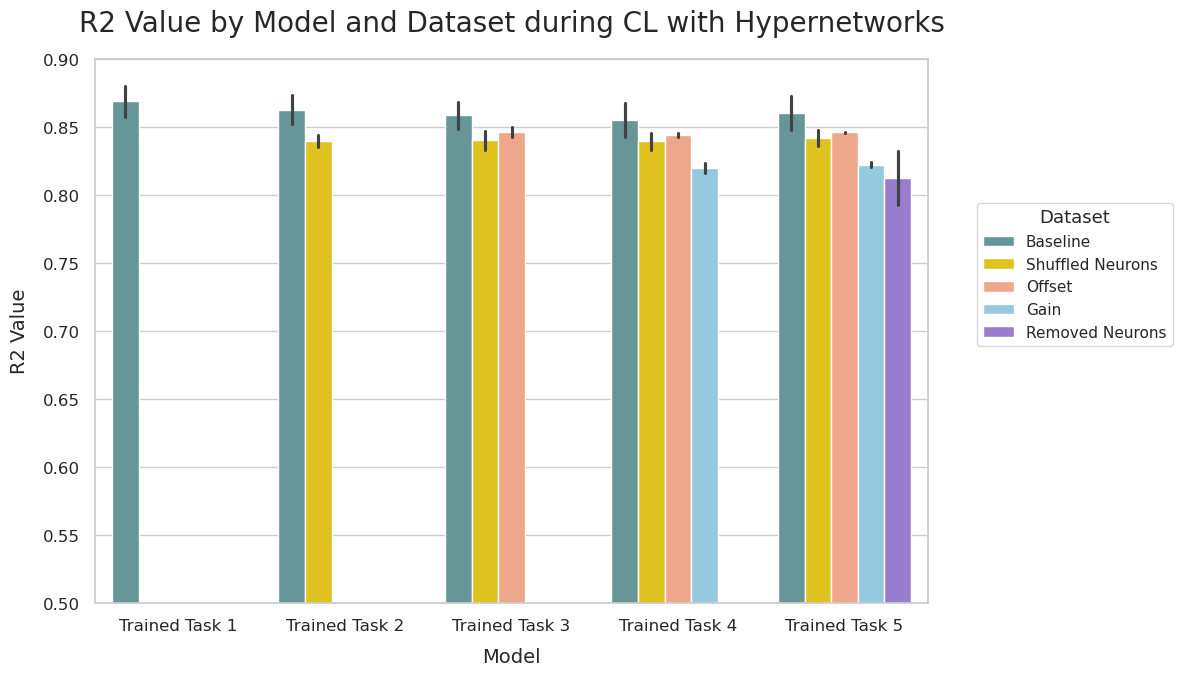

In [5]:
plot_catas_forg(df_exp0_v0)

#### Here the second version of the experiment, we will call it V1.

In [6]:
experiment0_hnet_v1 = 'Experiment78'
models_exp0_hnet_v1 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v1)))


path_results_exp0_v1 = './Results/' + experiment0_hnet_v1
with open(os.path.join(path_results_exp0_v1 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v1 = pickle.load(fp)

data_path_exp0_v1 = './Data/Sim_Data_'+'Experiment60_sorted_v2'+'.pkl'
with open(os.path.join(data_path_exp0_v1), 'rb') as fp:
    data_exp0_v1 = pickle.load(fp)


In [7]:
df_exp0_v1 = build_catas_forg_df(results_hnet_exp0_v1, data_exp0_v1, models_exp0_hnet_v1, experiment0_hnet_v1)

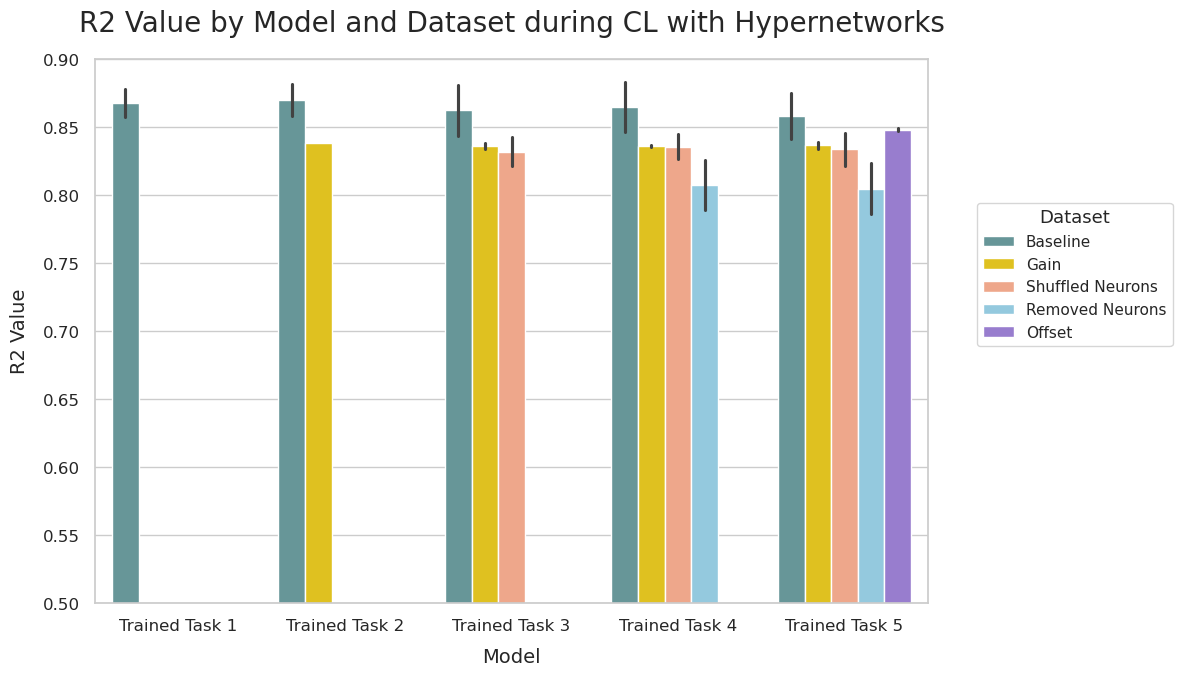

In [8]:
plot_catas_forg(df_exp0_v1)

#### Here the third version of the experiment, we will call it V2.

In [9]:
experiment0_hnet_v2 = 'Experiment79'
models_exp0_hnet_v2 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v2)))


path_results_exp0_v2 = './Results/' + experiment0_hnet_v2
with open(os.path.join(path_results_exp0_v2 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v2 = pickle.load(fp)

data_path_exp0_v2 = './Data/Sim_Data_'+'Experiment60_sorted_v3'+'.pkl'
with open(os.path.join(data_path_exp0_v2), 'rb') as fp:
    data_exp0_v2 = pickle.load(fp)


In [10]:
df_exp0_v2 = build_catas_forg_df(results_hnet_exp0_v2, data_exp0_v2, models_exp0_hnet_v2, experiment0_hnet_v2)

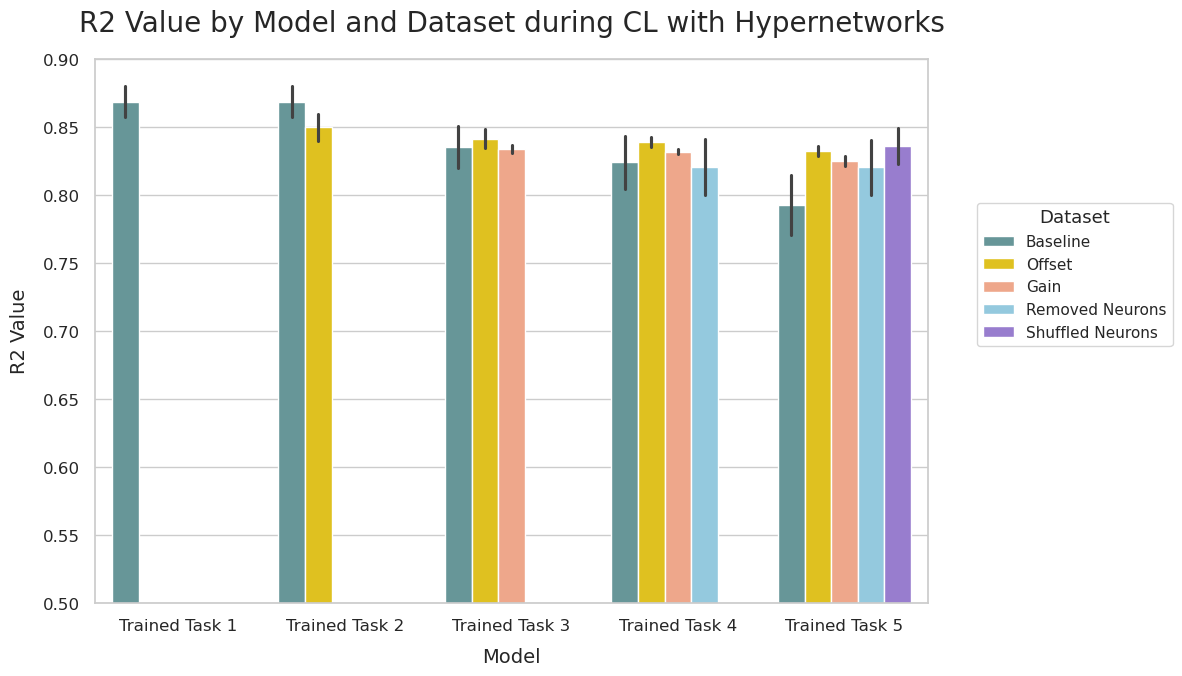

In [11]:
plot_catas_forg(df_exp0_v2)

# Experiment 1: Comparison with other methods

In [12]:
experiment0_control = 'Experiment76_control'
models_exp0_control = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_control)))

path_results_exp0_control = './Results/' + experiment0_control
with open(os.path.join(path_results_exp0_control +'.pkl'), 'rb') as fp:
    results_exp0_control = pickle.load(fp)

data_path_exp0_control = './Data/Sim_Data_'+'Experiment60_sorted'+'.pkl'

with open(os.path.join(data_path_exp0_control), 'rb') as fp:
    data_exp0_control = pickle.load(fp)

Define the dataframes for each experiment. 

In [13]:
df_exp0_control = build_result_df(results_exp0_control, data_exp0_control)
df_exp0_hnet_v0 = build_result_df(results_hnet_exp0_v0, data_exp0_v0)
df_exp0_hnet_v1 = build_result_df(results_hnet_exp0_v1, data_exp0_v1)
df_exp0_hnet_v2 = build_result_df(results_hnet_exp0_v2, data_exp0_v2)

Keep only the tasks learned and sort the dataframes in the order of the learned tasks.

In [14]:
# For the first version of the experiment
df_exp0_hnet_new_v0 = df_exp0_hnet_v0.loc[df_exp0_hnet_v0.New_Task == True].reset_index()
df_exp0_hnet_new_v0.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v0 = df_exp0_hnet_new_v0.reset_index()

# For the second version of the experiment
df_exp0_hnet_new_v1 = df_exp0_hnet_v1.loc[df_exp0_hnet_v1.New_Task == True].reset_index()
df_exp0_hnet_new_v1.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v1 = df_exp0_hnet_new_v1.reset_index()

# For the third version of the experiment
df_exp0_hnet_new_v2 = df_exp0_hnet_v2.loc[df_exp0_hnet_v2.New_Task == True].reset_index()
df_exp0_hnet_new_v2.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v2 = df_exp0_hnet_new_v2.reset_index()

# For the control experiment
df_exp0_control_new = df_exp0_control.loc[df_exp0_control.New_Task == True].reset_index()
df_exp0_control_new.sort_values(by='Dataset', inplace=True)
df_exp0_control_new = df_exp0_control.reset_index().drop(columns = ['index'])

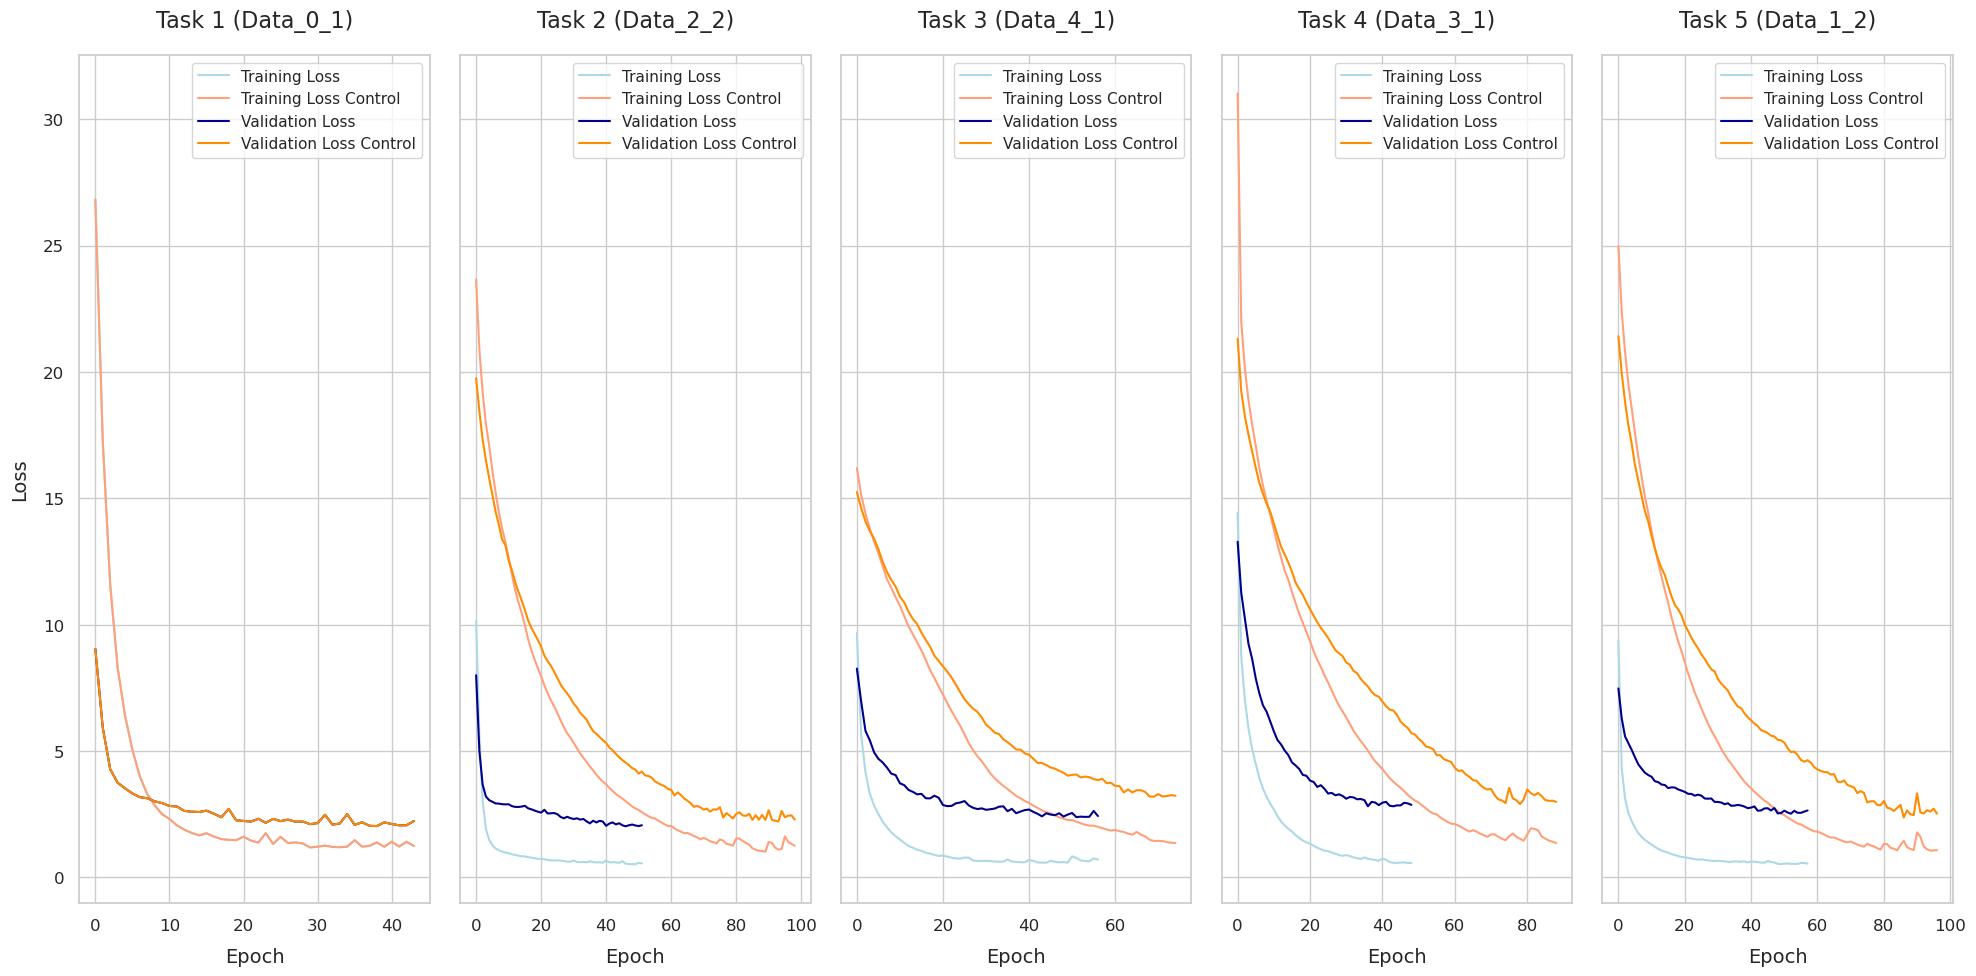

In [15]:
plot_learning_curves(df_exp0_hnet_new_v0, df_exp0_control)

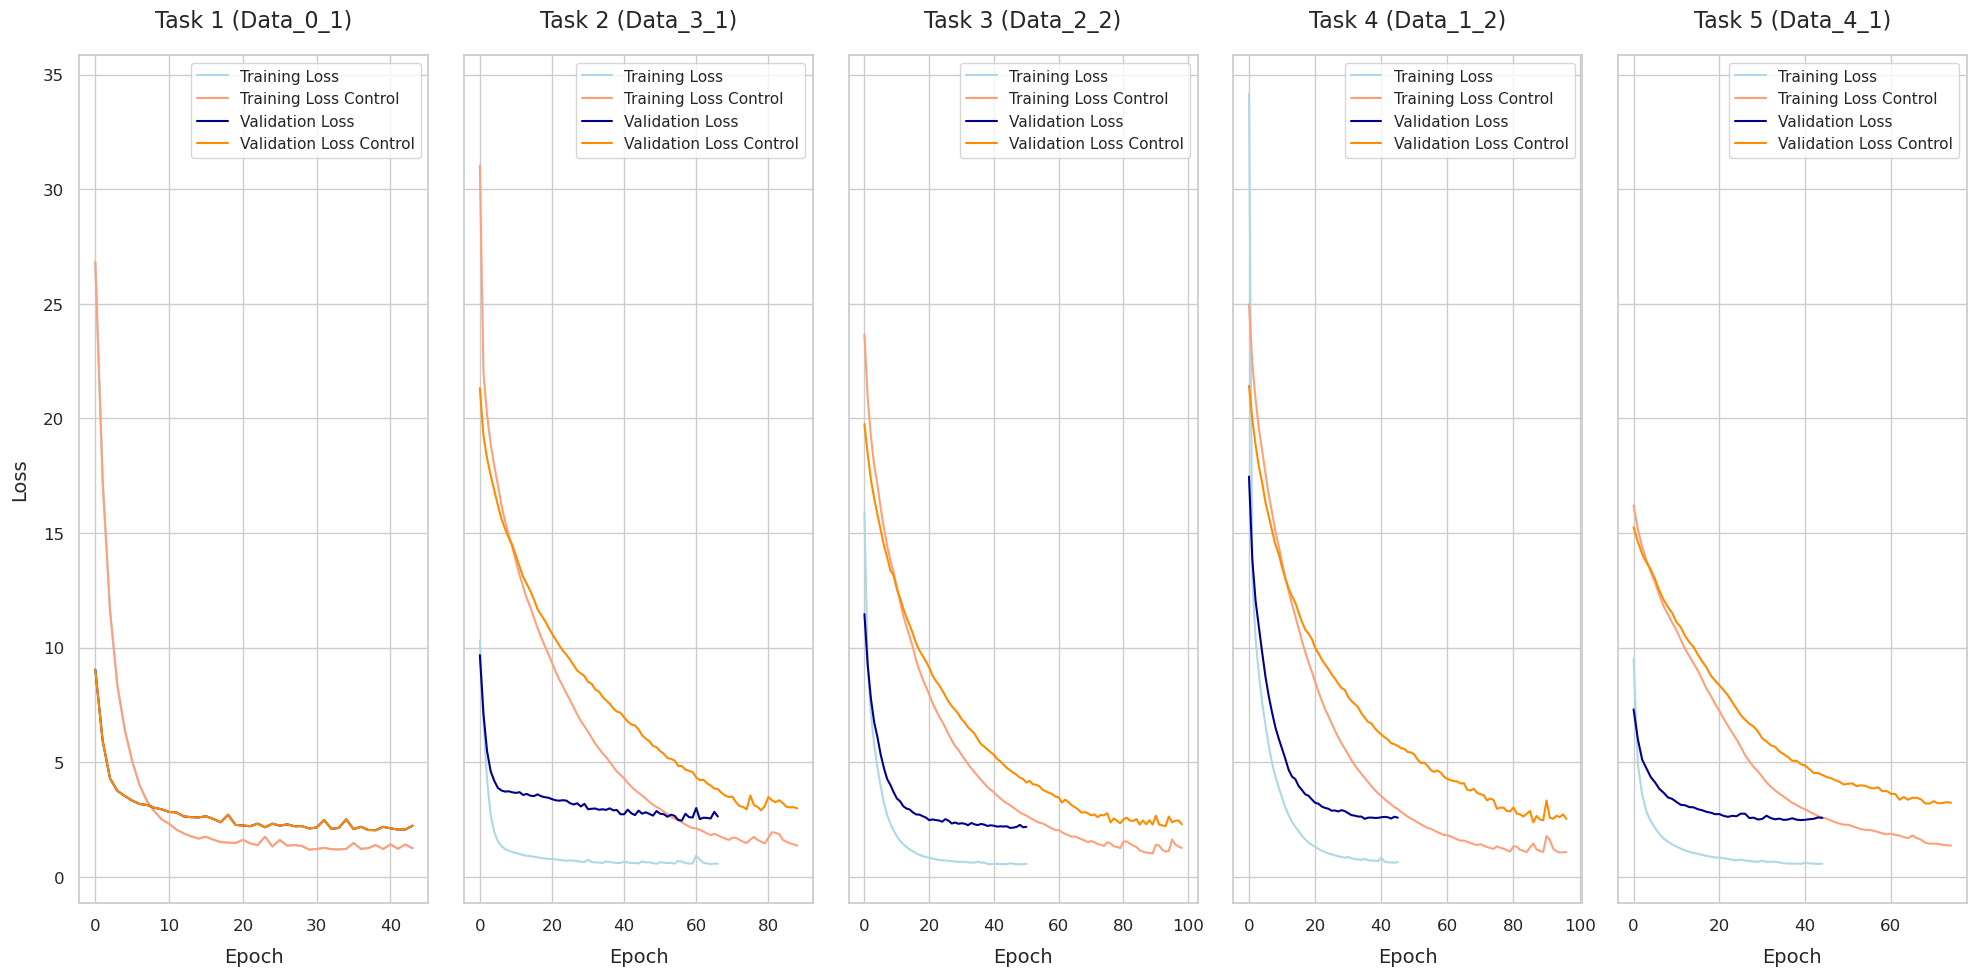

In [16]:
plot_learning_curves(df_exp0_hnet_new_v1, df_exp0_control)

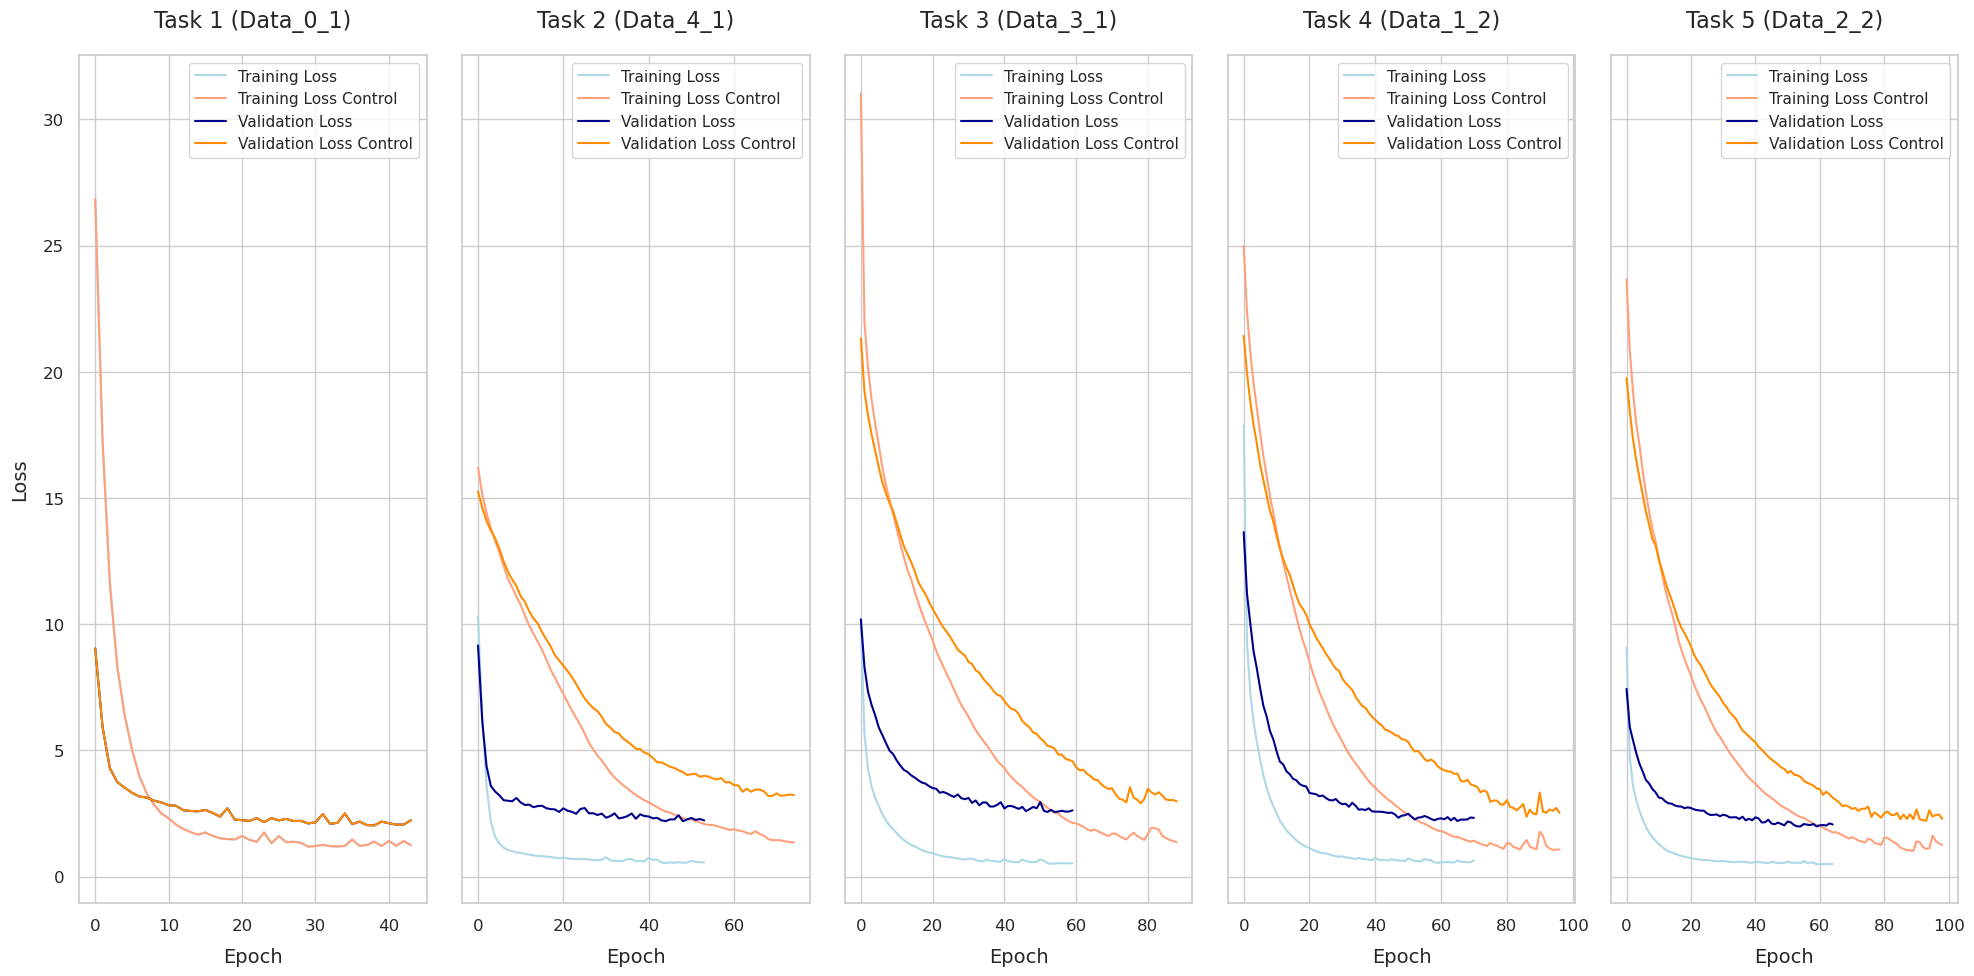

In [17]:
plot_learning_curves(df_exp0_hnet_new_v2, df_exp0_control)

### Including the other methods: EWC and Fine Tuning.

#### Start with the first version

In [18]:
experiment1_EWC_v0 = 'Experiment77_EWC'

path_to_ewc = './Models/Models_EWC'
models_exp1_EWC_v0 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v0)))

path_results_exp1_EWC_v0 = './Results/' + experiment1_EWC_v0
with open(os.path.join(path_results_exp1_EWC_v0 +'.pkl'), 'rb') as fp:
    results_exp1_EWC_v0 = pickle.load(fp)

data_path_exp1_EWC_v0 = './Data/Sim_Data_'+'Experiment60_sorted_first5'+'.pkl'
with open(os.path.join(data_path_exp1_EWC_v0), 'rb') as fp:
    data_exp1_EWC_v0 = pickle.load(fp)

In [19]:
df_exp1_EWC_v0 = build_result_df(results_exp1_EWC_v0, data_exp1_EWC_v0, EWC = True)

In [20]:
df_exp1_EWC_plot_v0 = build_catas_forg_df(results_exp1_EWC_v0, \
    data_exp1_EWC_v0, 
    models_exp1_EWC_v0, 
    experiment1_EWC_v0, 
    model_type = 'EWC')

In [21]:
r2_ewc_v0 = df_exp1_EWC_plot_v0.loc[df_exp1_EWC_plot_v0.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ewc_v0.rename(columns={'R2': 'EWC Model'}, inplace=True)

### Second version

In [22]:
experiment1_EWC_v1 = 'Experiment92'

path_to_ewc = './Models/Models_EWC'
models_exp1_EWC_v1 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v1)))

path_results_exp1_EWC_v1 = './Results/' + experiment1_EWC_v1
with open(os.path.join(path_results_exp1_EWC_v1 + '_EWC.pkl'), 'rb') as fp:
    results_exp1_EWC_v1 = pickle.load(fp)

data_path_exp1_EWC_v1 = './Data/Sim_Data_Experiment60_sorted_first5_v2' + '.pkl'
with open(os.path.join(data_path_exp1_EWC_v1), 'rb') as fp:
    data_exp1_EWC_v1 = pickle.load(fp)

df_exp1_EWC_v1 = build_result_df(results_exp1_EWC_v1, data_exp1_EWC_v1, EWC=True)
df_exp1_EWC_plot_v1 = build_catas_forg_df(results_exp1_EWC_v1, 
                                          data_exp1_EWC_v1, 
                                          models_exp1_EWC_v1, 
                                          experiment1_EWC_v1, 
                                          model_type='EWC')
r2_ewc_v1 = df_exp1_EWC_plot_v1.loc[df_exp1_EWC_plot_v1.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ewc_v1.rename(columns={'R2': 'EWC Model'}, inplace=True)

### Third version

In [23]:
experiment1_EWC_v2 = 'Experiment93'

path_to_ewc = './Models/Models_EWC'
models_exp1_EWC_v2 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v2)))

path_results_exp1_EWC_v2 = './Results/' + experiment1_EWC_v2
with open(os.path.join(path_results_exp1_EWC_v2 + '_EWC.pkl'), 'rb') as fp:
    results_exp1_EWC_v2 = pickle.load(fp)

data_path_exp1_EWC_v2 = './Data/Sim_Data_Experiment60_sorted_first5_v3' + '.pkl'
with open(os.path.join(data_path_exp1_EWC_v2), 'rb') as fp:
    data_exp1_EWC_v2 = pickle.load(fp)

df_exp1_EWC_v2 = build_result_df(results_exp1_EWC_v2, data_exp1_EWC_v2, EWC=True)
df_exp1_EWC_plot_v2 = build_catas_forg_df(results_exp1_EWC_v2, 
                                          data_exp1_EWC_v2, 
                                          models_exp1_EWC_v2, 
                                          experiment1_EWC_v2, 
                                          model_type='EWC')
r2_ewc_v2 = df_exp1_EWC_plot_v2.loc[df_exp1_EWC_plot_v2.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ewc_v2.rename(columns={'R2': 'EWC Model'}, inplace=True)


### Now for the Fine Tuning version

In [25]:
# For v0
experiment1_FT_v0 = 'Experiment77_FT'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v0 = np.sort(os.listdir(os.path.join(path_to_ft, 'Experiment77')))

path_results_exp1_FT_v0 = './Results/' + experiment1_FT_v0
with open(os.path.join(path_results_exp1_FT_v0 + '.pkl'), 'rb') as fp:
    results_exp1_FT_v0 = pickle.load(fp)

data_path_exp1_FT_v0 = './Data/Sim_Data_Experiment60_sorted_first5' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v0), 'rb') as fp:
    data_exp1_FT_v0 = pickle.load(fp)

df_exp1_FT_v0 = build_result_df(results_exp1_FT_v0, data_exp1_FT_v0, EWC=False)
df_exp1_FT_plot_v0 = build_catas_forg_df(results_exp1_FT_v0, 
                                         data_exp1_FT_v0, 
                                         models_exp1_FT_v0, 
                                         experiment1_FT_v0, 
                                         model_type='FT')


r2_ft_v0 = df_exp1_FT_plot_v0.loc[df_exp1_FT_plot_v0.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v0.rename(columns={'R2': 'FT Model'}, inplace=True)

KeyError: 'r2_test_detector'

In [ ]:


# For v1
experiment1_FT_v1 = 'Experiment92_FT'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v1 = np.sort(os.listdir(os.path.join(path_to_ft, experiment1_FT_v1)))

path_results_exp1_FT_v1 = './Results/' + experiment1_FT_v1
with open(os.path.join(path_results_exp1_FT_v1 + '.pkl'), 'rb') as fp:
    results_exp1_FT_v1 = pickle.load(fp)

data_path_exp1_FT_v1 = './Data/Sim_Data_Experiment60_sorted_first5_v2' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v1), 'rb') as fp:
    data_exp1_FT_v1 = pickle.load(fp)

df_exp1_FT_v1 = build_result_df(results_exp1_FT_v1, data_exp1_FT_v1, EWC=False)
df_exp1_FT_plot_v1 = build_catas_forg_df(results_exp1_FT_v1, 
                                         data_exp1_FT_v1, 
                                         models_exp1_FT_v1, 
                                         experiment1_FT_v1, 
                                         model_type='FT')
r2_ft_v1 = df_exp1_FT_plot_v1.loc[df_exp1_FT_plot_v1.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v1.rename(columns={'R2': 'FT Model'}, inplace=True)

# For v2
experiment1_FT_v2 = 'Experiment93_FT'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v2 = np.sort(os.listdir(os.path.join(path_to_ft, experiment1_FT_v2)))

path_results_exp1_FT_v2 = './Results/' + experiment1_FT_v2
with open(os.path.join(path_results_exp1_FT_v2 + '.pkl'), 'rb') as fp:
    results_exp1_FT_v2 = pickle.load(fp)

data_path_exp1_FT_v2 = './Data/Sim_Data_Experiment60_sorted_first5_v3' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v2), 'rb') as fp:
    data_exp1_FT_v2 = pickle.load(fp)

df_exp1_FT_v2 = build_result_df(results_exp1_FT_v2, data_exp1_FT_v2, EWC=False)
df_exp1_FT_plot_v2 = build_catas_forg_df(results_exp1_FT_v2, 
                                         data_exp1_FT_v2, 
                                         models_exp1_FT_v2, 
                                         experiment1_FT_v2, 
                                         model_type='FT')
r2_ft_v2 = df_exp1_FT_plot_v2.loc[df_exp1_FT_plot_v2.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v2.rename(columns={'R2': 'FT Model'}, inplace=True)


# Experiment 2: Task order effect

# Experiment 3: Determining the minimum trial number to learn and identify tasks